Monter le drive dans google colab

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import des librairies

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure
from bokeh.io import  push_notebook,output_notebook, show
from bokeh.models.widgets import Panel, Tabs
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool
import plotly.express as px
import statsmodels.api
output_notebook()  # pour un affichage en ligne

Import du fichier df au format csv dans google colab : si besoin, changer le chemin /content/...

In [88]:
# Gestion des dates au format date avec format européen
df= pd.read_csv('/content/df.csv', parse_dates=['Date'],dayfirst=True,index_col=0)

# La saison lue en tant que numérique est remise en chaine de caractère
df['Saison'] = df['Saison'].astype(str)

## Data visualisation

Préparation des données pour les visualisations : création d'une table avec tous les matchs de chaque équipe (chaque match apparait donc 2 fois, une fois avec les données de l'équipe à domicile et une fois avec les données de l'équipe à l'extérieur)

In [89]:
# Données des équipes à l'extérieur : nous ne conservons que les données de l'équipe "extérieur
df_by_teamext = df[['Equipe_exterieur','Equipe_domicile','Nb_buts_equipe_ext','Nb_buts_mi_temps_equipe_ext',
                    'Nb_tirs_equipe_ext','Nb_tirs_cadres_equipe_ext','Nb_fautes_equipe_ext','Corners_equipe_ext',
                    'Nb_cartons_J_equipe_ext','Nb_cartons_R_equipe_ext','Date','Saison','Resultat_match']]

dictionnaireext = {'Nb_buts_equipe_ext': 'Buts',
                'Nb_buts_mi_temps_equipe_ext': 'Buts_mi_temps',
                'Nb_tirs_equipe_ext': 'Nb_tirs',
                'Nb_tirs_cadres_equipe_ext': 'Nb_tirs_cadres',
                'Nb_fautes_equipe_ext': 'Nb_fautes',
                'Corners_equipe_ext': 'Corners',
                'Nb_cartons_J_equipe_ext': 'Carton_jaune',
                'Nb_cartons_R_equipe_ext': 'Carton_rouge',
                'Equipe_domicile': 'Adversaire',
                'Equipe_exterieur': 'Equipe'               
                }

# Renommage des données
df_by_teamext = df_by_teamext.rename(dictionnaireext, axis = 1)

# Cette variable indique si le match est à domicile (D) ou à l'extérieur (E)
df_by_teamext['D_E']="E"

# Création d'une nouvelle variable indiquant le nombre de points gagnés sur le match 
# (2 pour victoire, 1 pour nul et 0 pour défaite)
df_by_teamext['Nb_points']=df_by_teamext['Resultat_match']
df_by_teamext['Nb_points'].replace(to_replace = ['A', 'D', 'H'],value= [3,1,0],inplace=True)

# Création d'une victoire indiquant le résultat du match pour l'équipe étudiée
df_by_teamext['Resultat_match'].replace(to_replace = ['A', 'D', 'H'],value= ['Victoire','Nul','Défaite'],inplace=True)

# Mêmes étapes pour les équipes à domicile
df_by_teamdom = df[['Equipe_exterieur','Equipe_domicile','Nb_buts_equipe_dom','Nb_buts_mi_temps_equipe_dom',
                    'Nb_tirs_equipe_dom','Nb_tirs_cadres_equipe_dom','Nb_fautes_equipe_dom','Corners_equipe_dom',
                    'Nb_cartons_J_equipe_dom','Nb_cartons_R_equipe_dom','Date','Saison','Resultat_match']]

dictionnairedom = {'Nb_buts_equipe_dom': 'Buts',
                'Nb_buts_mi_temps_equipe_dom': 'Buts_mi_temps',
                'Nb_tirs_equipe_dom': 'Nb_tirs',
                'Nb_tirs_cadres_equipe_dom': 'Nb_tirs_cadres',
                'Nb_fautes_equipe_dom': 'Nb_fautes',
                'Corners_equipe_dom': 'Corners',
                'Nb_cartons_J_equipe_dom': 'Carton_jaune',
                'Nb_cartons_R_equipe_dom': 'Carton_rouge',
                'Equipe_domicile': 'Equipe',
                'Equipe_exterieur': 'Adversaire'               
                }

df_by_teamdom = df_by_teamdom.rename(dictionnairedom, axis = 1)

df_by_teamdom['D_E']="D"
df_by_teamdom['Nb_points']=df_by_teamdom['Resultat_match']
df_by_teamdom['Nb_points'].replace(to_replace = ['H', 'D', 'A'],value= [3,1,0],inplace=True)
df_by_teamdom['Resultat_match'].replace(to_replace = ['H', 'D', 'A'],value= ['Victoire','Nul','Défaite'],inplace=True)

# Concaténation des 2 dataframes
df_by_team = pd.concat([df_by_teamext, df_by_teamdom])


# Heatmaps des caractéristiques des clubs par saison

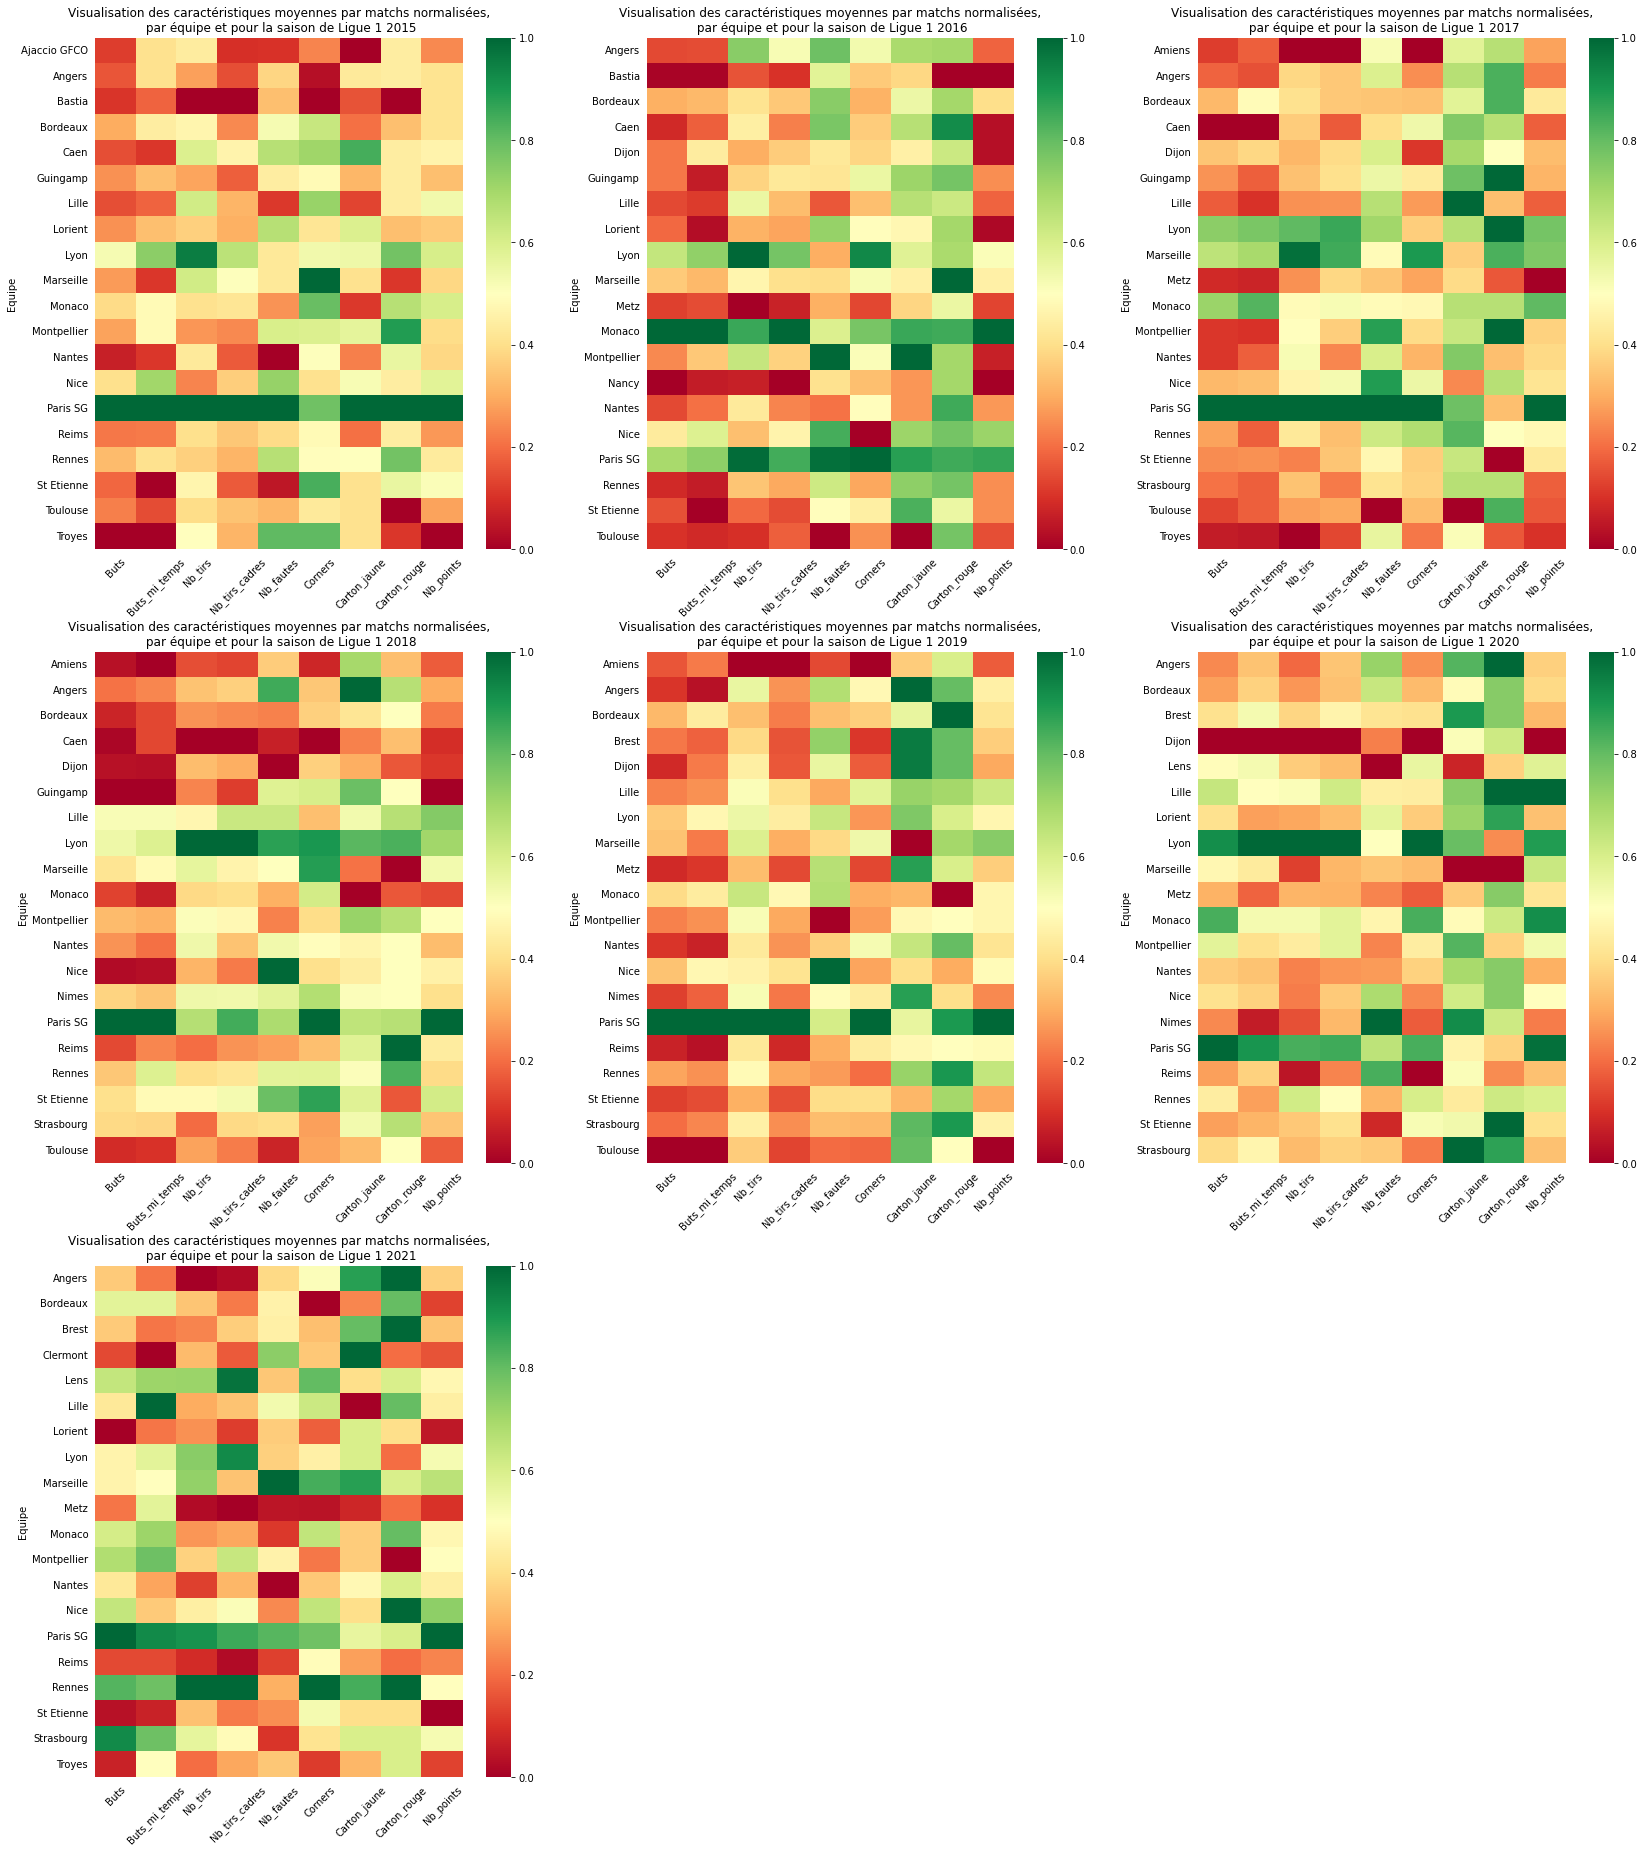

In [90]:
# Les données suivantes sont d'aspect "négatifs" : 2 cartons jaunes sont moins bons que 0.
# On va donc mettre les données en négatif pour le heat map
df_by_team_heat=df_by_team.copy()
df_by_team_heat['Nb_fautes']=-df_by_team_heat['Nb_fautes']
df_by_team_heat['Carton_jaune']=-df_by_team_heat['Carton_jaune']
df_by_team_heat['Carton_rouge']=-df_by_team_heat['Carton_rouge']

# Liste des saisons étudiées
saison = ['2015','2016','2017','2018','2019','2020','2021']

# Emplacement des graphiques
place = [331,332,333,334,335,336,337 ]

fig = plt.figure(figsize=(28,32))

from sklearn.preprocessing import StandardScaler,MinMaxScaler

for i in saison :
  # Conservation des données de la saison i
  df_saison = df_by_team_heat[df_by_team_heat['Saison']==i].drop(['Saison'],axis=1)
  
  # Agrégation des variables pour obtenir la moyenne par équipe
  df_heatmap = df_saison[['Buts','Buts_mi_temps','Nb_tirs','Nb_tirs_cadres','Nb_fautes','Corners',
                          'Carton_jaune','Carton_rouge','Nb_points','Equipe']].groupby(['Equipe']).mean()
  
  # Tranfsormation pour obtenir des échelles comparables
  minmax_scaler = MinMaxScaler().fit_transform(df_heatmap.values)
  df_saison_bar = pd.DataFrame(minmax_scaler, index=df_heatmap.index, columns=df_heatmap.columns)

  # Création du graphique
  plt.subplot(place[saison.index(i)])
  p = sns.heatmap(df_saison_bar, cmap="RdYlGn")
  plt.title("Visualisation des caractéristiques moyennes par matchs normalisées,\n par équipe et pour la saison de Ligue 1 " + i)
  p.set_xticklabels(p.get_xticklabels(),rotation = 45)
  p.tick_params(left=False, bottom=False)

# sauvegarde du graphique
fig.savefig('Caracteristique_clubs.png', dpi=200, bbox_inches = 'tight') ;

Les heatmaps précédentes permettent de voir que le PSG est toujours dans les meilleures équipes sur toutes les caractéristiques (beaucoup de vert). 

En 2016 et 2020, 2 autres équipes ont été championnes. En 2016, la bonne saison de Monaco ressort sur toutes les caractéristiques, alors qu'en 2020, où c'est Lille qui devient champion, cette équipe ne ressort que sur le nombre de points moyens (ce qui est évident) et sur le nombre de cartons rouges peu nombreux.

Cette visualisation met aussi en évidence les équipes qui vont descendre (beaucoup de rouge), même s'il y a quelques incohérences comme Bastia en 2015 dont les statistiques sont mauvaises mais qui ne descend pas. 

# Pourcentage de victoires / défaites / nuls par équipe et saison

In [91]:
# Couleurs utilisées dans le bar chart, le dernier correspond à du bordeaux
cols = ['navy','white','#922b21']

hover = HoverTool(
        tooltips=[
            ("Victoire", "@Victoire{:.2%}"),
            ("Nul", "@Nul{:.2%}"),
            ("Défaite", "@{Défaite}{:.2%}")
             ])

dictionnaire = {}

# Récupérer toutes les saisons
saisons = pd.unique(df['Saison'])

# Le même graphique est effectué sur toutes les saisons, on boucle sur chacune d'elles
for saison in saisons:

  # Récupérer les données de la saison
  df_statsaison = df_by_team[df_by_team['Saison']==saison].drop(['Saison'],axis=1)

  # Calculer les agrégations des résultats des matchs par équipe
  dictionnaire['ctab_'+saison]=pd.crosstab(df_statsaison['Equipe'],
              df_statsaison['Resultat_match'],rownames=['Equipe'],colnames=['Resultat_match'],
              normalize = 'index').reset_index()
  dictionnaire['ctab_'+saison].sort_values(['Victoire','Nul'], ascending=True,inplace=True)
  dictionnaire['source'+saison]=ColumnDataSource(dictionnaire['ctab_'+saison])  
  
  # Création du bar chart de la saison
  dictionnaire['p'+saison]=figure(y_range = dictionnaire['ctab_'+saison].Equipe, plot_width = 400, plot_height = 400)
  dictionnaire['p'+saison].hbar_stack(['Victoire','Défaite','Nul'], y='Equipe', color = cols, height=0.5, source=dictionnaire['ctab_'+saison],line_color='black', legend_label=['Victoire','Nul','Défaite'])
  dictionnaire['p'+saison].add_tools(hover)
  dictionnaire['p'+saison].legend.location = "center_right"
  dictionnaire['p'+saison].legend.background_fill_alpha = 0.8
  dictionnaire['p'+saison].title.text = 'Pourcentage de V/D/N par équipe et saison'
  dictionnaire['tab'+saison] = Panel(child=dictionnaire['p'+saison], title="Saison"+ saison)

tabs = Tabs(tabs=[ dictionnaire['tab2015'],dictionnaire['tab2016'],dictionnaire['tab2017'],dictionnaire['tab2018'],dictionnaire['tab2019'],dictionnaire['tab2020'],dictionnaire['tab2021']])

show(tabs)


Cette visualisation permet de voir les différences de pourcentage de victoire/nul/défaite entre les équipes de haut de tableau et celles de bas de tableau. 

L'équipe avec le plus de victoires n'est pas toujours celle qui gagnera le championnat. En 2020, le PSG a gagné plus de matchs que Lille mais a aussi concédé beaucoup plus de défaites. C'est la constance des résultats de Lille qui leur a permis d'être champion de France.

Nous pouvons aussi voir qu'il y a une différence assez significative entre les pourcentages de victoires des 4 ou 5 premiers du championnat et les autres équipes.

# Nombre de tirs moyens par match selon le lieu du match

Hypothèse que l'on veut vérifier : le fait d'être à domicile a-t-il un effet sur le nombre de tirs effectués.
Pour cela, nous allons tout d'abord effectuer un bar chart du nombre de tirs par match selon le lieu du match

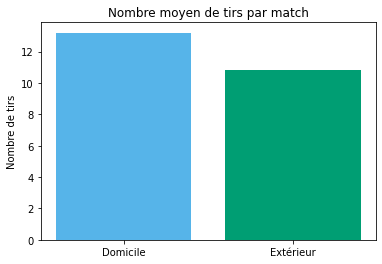

In [92]:
# Calcul du nombre de tirs moyens selon Domicile/Extérieur
moy_tir = df_by_team.groupby("D_E").mean(['Nb_tirs']).reset_index()

# Création du bar chart
plt.bar(moy_tir.D_E,moy_tir.Nb_tirs, color=["#56B4E9", "#009E73"]);
plt.ylabel('Nombre de tirs')
plt.xticks([0,1],['Domicile', 'Extérieur'])
plt.title('Nombre moyen de tirs par match')
plt.savefig('Moyenne_tirs.png', dpi=200, bbox_inches = 'tight') ;

Visuellement, le fait d'être à domicile semble avoir une influence sur le nombre de tirs.

Nous allons le vérifier statistiquement.

Soit l'hypothèse H_0 : "Le nombre de tirs est indépendant du lieu du match (domicile / extérieur)"

Variables à considérer : 

- l'équipe est à domicile ou à l'extérieur

- le nombre de tirs effectués

In [93]:
# Calcul de l'ANOVA
result = statsmodels.formula.api.ols('Nb_tirs ~ D_E', data = df_by_team).fit() 
table = statsmodels.api.stats.anova_lm(result)
table

,df,sum_sq,mean_sq,F,PR(>F)
D_E,1.0,6893.765638,6893.765638,332.268527,7.830045e-72
Residual,4794.0,99463.866555,20.747573,NaN,NaN


La p-value est inférieure à  5%, on rejette l'hypothèse nulle.
On peut conclure que le le fait de jouer à domicile a un effet statistique significatif sur le nombre de tirs durant un match.

# Matrice de correlation

In [94]:
# Calcul des corrélations de Pearson sur les variables quantitatives
corr = df.corr()

# Affichage de la heatmap de ces corrélations
corr.style.background_gradient(cmap='Reds')


,Nb_buts_equipe_dom,Nb_buts_equipe_ext,Nb_buts_mi_temps_equipe_dom,Nb_buts_mi_temps_equipe_ext,Nb_tirs_equipe_dom,Nb_tirs_equipe_ext,Nb_tirs_cadres_equipe_dom,Nb_tirs_cadres_equipe_ext,Nb_fautes_equipe_dom,Nb_fautes_equipe_ext,Corners_equipe_dom,Corners_equipe_ext,Nb_cartons_J_equipe_dom,Nb_cartons_J_equipe_ext,Nb_cartons_R_equipe_dom,Nb_cartons_R_equipe_ext,Nb_total_but_match,Moy_cote_domicile,Max_cote_domicile,Min_cote_domicile,Moy_cote_exterieur,Max_cote_exterieur,Min_cote_exterieur,Moy_cote_nul,Max_cote_nul,Min_cote_nul
Nb_buts_equipe_dom,1.000000,-0.118776,0.671595,-0.049100,0.264352,-0.054996,0.596054,-0.093565,-0.094872,-0.058361,-0.004674,0.024407,-0.082695,-0.020004,-0.105951,0.098301,0.717703,-0.225713,-0.214373,-0.233297,0.356366,0.335664,0.370532,0.281028,0.282855,0.268455
Nb_buts_equipe_ext,-0.118776,1.000000,-0.044338,0.687788,-0.064109,0.302765,-0.121170,0.577368,-0.011976,-0.077725,-0.014818,0.021341,0.093348,-0.053189,0.154357,-0.099976,0.606175,0.320682,0.314584,0.325031,-0.207377,-0.190710,-0.221910,-0.022730,-0.026268,-0.021325
Nb_buts_mi_temps_equipe_dom,0.671595,-0.044338,1.000000,-0.031345,0.081540,0.072910,0.369378,0.000531,-0.045915,-0.053610,-0.083273,0.117065,-0.047539,-0.026257,-0.048635,0.041686,0.506854,-0.162757,-0.155709,-0.167081,0.248812,0.233192,0.260833,0.201417,0.202907,0.192025
Nb_buts_mi_temps_equipe_ext,-0.049100,0.687788,-0.031345,1.000000,0.044426,0.144440,-0.039305,0.371244,-0.008779,-0.055377,0.090815,-0.039927,0.069351,-0.026502,0.080280,-0.042283,0.443026,0.201054,0.194108,0.209367,-0.141917,-0.130493,-0.149476,-0.022228,-0.024386,-0.019424
Nb_tirs_equipe_dom,0.264352,-0.064109,0.081540,0.044426,1.000000,-0.253617,0.635234,-0.138883,-0.126235,-0.056064,0.490002,-0.240749,-0.078104,0.028832,-0.143086,0.132465,0.166786,-0.241569,-0.230616,-0.249572,0.302165,0.281961,0.312207,0.203386,0.203579,0.198378
Nb_tirs_equipe_ext,-0.054996,0.302765,0.072910,0.144440,-0.253617,1.000000,-0.147285,0.661923,-0.009459,-0.113121,-0.251263,0.458978,0.044045,-0.117432,0.163725,-0.140800,0.168282,0.320229,0.314559,0.324486,-0.181009,-0.164697,-0.197621,0.009686,0.007280,0.012042
Nb_tirs_cadres_equipe_dom,0.596054,-0.121170,0.369378,-0.039305,0.635234,-0.147285,1.000000,-0.129203,-0.092753,-0.049077,0.258345,-0.083292,-0.060644,0.017682,-0.116199,0.111853,0.392462,-0.241535,-0.231326,-0.247210,0.331389,0.311001,0.343974,0.244443,0.245821,0.238587
Nb_tirs_cadres_equipe_ext,-0.093565,0.577368,0.000531,0.371244,-0.138883,0.661923,-0.129203,1.000000,-0.014711,-0.106756,-0.128486,0.263771,0.055299,-0.094168,0.142304,-0.116354,0.329970,0.304921,0.300951,0.305257,-0.189879,-0.175046,-0.202740,-0.010044,-0.014050,-0.007771
Nb_fautes_equipe_dom,-0.094872,-0.011976,-0.045915,-0.008779,-0.126235,-0.009459,-0.092753,-0.014711,1.000000,0.134083,-0.100613,-0.049429,0.299783,0.069298,0.018796,0.046950,-0.084392,0.031123,0.027658,0.032292,-0.128152,-0.126633,-0.126777,-0.133553,-0.132995,-0.132812
Nb_fautes_equipe_ext,-0.058361,-0.077725,-0.053610,-0.055377,-0.056064,-0.113121,-0.049077,-0.106756,0.134083,1.000000,-0.057713,-0.069087,0.067609,0.367462,0.036750,0.048164,-0.101257,-0.080566,-0.082225,-0.080065,-0.058294,-0.059315,-0.061110,-0.131127,-0.126385,-0.137606


Les seules corrélations élevées sont logiques, c'est-à-dire le nombre de tirs cadrés et le nombre de buts (même si on aurait pu s'attendre à une corrélation plus élevée (0.59 à domicile ou 0.57 à l'extérieur)),
le nombre de buts à la mi-temps et le nombre total à la fin du match.
Contre toute attente, le nombre de corners ne semble pas du tout corrélé avec le nombre de buts (corrélation très proche de 0).

# Nombre de buts par match à domicile et à l'extérieur

In [95]:
# Création d'un dataframe spécifique pour modifier des variables
df_box = df
df_box['Nb_buts_equipe_ext']=df_box['Nb_buts_equipe_ext'].replace([6,7,8,9], [5,5,5,5]) 
df_box['Nb_buts_equipe_dom']=df_box['Nb_buts_equipe_dom'].replace([6,7,8,9], [5,5,5,5]) 

In [96]:
# Création du box plot des données à domicile
fig=px.box(data_frame=df_box.sort_values(['Saison','Nb_buts_equipe_dom']),y='Nb_tirs_cadres_equipe_dom',facet_col='Nb_buts_equipe_dom',color='Saison',
 labels={
                     "Nb_tirs_cadres_equipe_dom": "Nombre de tirs cadrés à domicile",
                     'Nb_buts_equipe_dom': ""
                 })
fig.update_layout(title_text='Nombre de buts par match à domicile (5 correspond à 5 buts et plus)', title_x=0.5)

In [97]:
# Création du box plot des données à l'extérieur
fig = px.box(data_frame=df_box.sort_values(['Saison','Nb_buts_equipe_ext']),y='Nb_tirs_cadres_equipe_ext',facet_col='Nb_buts_equipe_ext',color='Saison',
             labels={
                     "Nb_tirs_cadres_equipe_ext": "Nombre de tirs cadrés à l'extérieur",
                     'Nb_buts_equipe_ext': ""
                 })
fig.update_layout(title_text="Nombre de buts par match à l'extérieur (5 correspond à 5 buts et plus)", title_x=0.5)

Nous observons bien une hausse du nombre de tirs en fonction du nombre de but. 

Les médianes du nombre de tirs sont assez stables d'une saison à l'autre sur les nombres de buts faibles. A partir de 4 buts, les dispersions sont plus importantes. 

Ces graphiques mettent aussi en évidence quelques outliers, comme par exemple 11 tirs cadrés pour aucun but en 2016 (Bastia/Dijon).

# Graphique des gains en suivant les cotes des bookmakers

Recherche des gains par saison en partant d'une enveloppe de 1000 euros et en misant 10 € par match sur la cote la plus élevée du résultat le plus probable

In [98]:
# Nous ne gardons que les données de cote
df_cote=df[['Saison','Equipe_domicile','Equipe_exterieur','Resultat_match','Moy_cote_domicile','Max_cote_domicile','Min_cote_domicile','Moy_cote_exterieur','Max_cote_exterieur','Min_cote_exterieur','Moy_cote_nul',
           'Max_cote_nul','Min_cote_nul']]

In [ ]:
# Recherche du résultat le plus probable
# Le résultat le plus probable pour les bookmakers est celui avec la cote la plus faible
df_cote['Cote_result_plus_probable']=df_cote[['Max_cote_domicile','Max_cote_exterieur','Max_cote_nul']].min(axis=1)

# Récupération de la modalité la plus probable
df_cote.loc[df_cote['Cote_result_plus_probable'] == df_cote['Max_cote_domicile'], 'Result_plus_probable'] = 'H'
df_cote.loc[df_cote['Cote_result_plus_probable'] == df_cote['Max_cote_exterieur'], 'Result_plus_probable'] = 'A' 
df_cote.loc[df_cote['Cote_result_plus_probable'] == df_cote['Max_cote_nul'], 'Result_plus_probable'] = 'D'

# Mise de départ
df_cote[['gain_perte']] = -10

# Si bon pari, calcul du gain : cote * mise - mise
df_cote.loc[df_cote['Resultat_match'] == df_cote['Result_plus_probable'], 'gain_perte'] = 10 * df_cote['Cote_result_plus_probable'] - 10

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from io import StringIO

import pylab as pl
df = pd.DataFrame(np.random.rand(10, 2), columns=["left", "right"])
df["left"] *= 100

ax = df.plot(kind="bar")
ax2 = ax.twinx()
for r in ax.patches[len(df):]:
    r.set_transform(ax2.transData)
ax2.set_ylim(0, 2);

_ = df.plot( kind= 'bar' , secondary_y= 'amount' , rot= 0 )
plt.show()

In [ ]:
# Calcul des cumuls des montants
# La somme de départ est de 1 000 €
df_cote['gain_perte_tot'] = df_cote.groupby(['Saison'])['gain_perte'].cumsum()+1000

# Numéro du match de la saison
df_cote['x'] = 1
df_cote['x'] = df_cote.groupby(['Saison'])['x'].cumsum()

In [163]:
# Pour affichage par saison
df_cote.set_index(['x'], inplace=True)

Affichage d'un plot des gains par saison en partant d'une enveloppe de 1000 euros

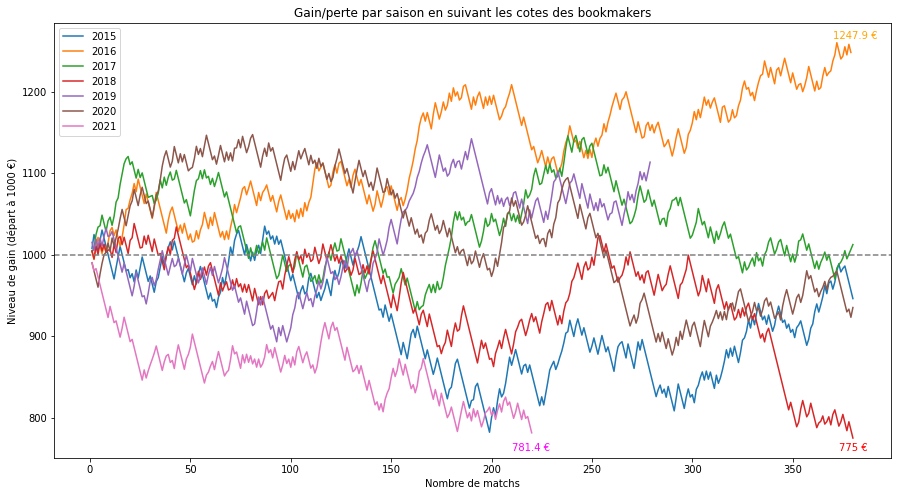

In [164]:
ax=plt.figure(figsize = (15, 8))
df_cote.groupby('Saison')['gain_perte_tot'].plot(legend=True)
plt.title('Gain/perte par saison en suivant les cotes des bookmakers')
plt.xlabel("Nombre de matchs")
plt.ylabel("Niveau de gain (départ à 1000 €)")
plt.axhline(y=1000,color='gray',linestyle='--')

# Affichage de 3 montants finaux
plt.text(370, 1265, '1247.9 €', color='orange')
plt.text(373, 760, '775 €', color='r')
plt.text(210, 760, '781.4 €', color='fuchsia')
plt.savefig('Gain_bookmakers.png', dpi=200, bbox_inches = 'tight') ;

En suivant les cotes des bookmakers, nous aurions gagné de l'argent 3 années sur les 6 saisons entières (très peu en 2017) mais environ 250 € en 2016. Les pertes auraient été importantes en 2018 (perte de 225 €). Le début de saison 2021-2022 ne laisse pas présager de bons résultats avec une perte assez importante à mi-saison.

Pourcentage de bonnes prévisions des bookmakers

In [ ]:
df_pct_booky=df_cote[['Saison','Equipe_domicile','Equipe_exterieur','Resultat_match','Result_plus_probable']]
df_pct_booky.loc[df_cote['Resultat_match'] == df_pct_booky['Result_plus_probable'], 'Modele_ok_ko'] = "OK"
df_pct_booky.loc[df_cote['Resultat_match'] != df_pct_booky['Result_plus_probable'], 'Modele_ok_ko'] = "KO"

In [156]:
prep_graph=pd.crosstab(df_pct_booky['Resultat_match'],df_pct_booky['Modele_ok_ko'],normalize=True, margins=True)
display(prep_graph)
pct_column=pd.crosstab(df_pct_booky['Resultat_match'],df_pct_booky['Modele_ok_ko'],normalize='index')
pct_column

Modele_ok_ko,KO,OK,All
Resultat_match,,,
A,0.158882,0.138032,0.296914
D,0.264804,0.000417,0.265221
H,0.064220,0.373645,0.437865
All,0.487907,0.512093,1.000000


Modele_ok_ko,KO,OK
Resultat_match,,
A,0.535112,0.464888
D,0.998428,0.001572
H,0.146667,0.853333


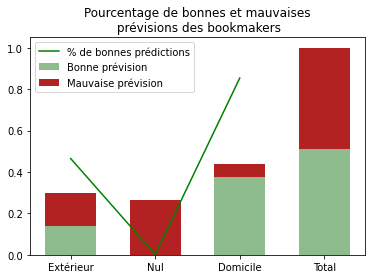

In [161]:
category_labels = ['Extérieur', 'Nul', 'Domicile', 'Total']

plt.bar(prep_graph.index ,prep_graph['OK'], color = 'darkseagreen', width = 0.6,label='Bonne prévision') 
plt.bar(prep_graph.index , prep_graph['KO'], bottom=prep_graph['OK'], color = 'firebrick', width = 0.6,label='Mauvaise prévision') 
plt.plot(pct_column['OK'],label='% de bonnes prédictions',color ='g')
plt.xticks(['A','D','H','All'], category_labels)
plt.title('Pourcentage de bonnes et mauvaises\n prévisions des bookmakers')
plt.legend()
plt.savefig('Previsions_bookmakers.png', dpi=200, bbox_inches = 'tight') ;

Le pourcentage de bonnes prédictions des bookmakers est de 51,2 %. Les bookmakers prévoient très mal les matchs nuls mais quand il y a une victoire à domicile, ils l'avaient en bien prévu à plus de 85 % de fois.

In [165]:
# Export du csv df_by_team dans google colab pour réutilisation dans le feature engineering
df_by_team.to_csv('/content/df_by_team.csv')